In [7]:
import pandas as pd
from glob import glob
import os

# Directory where your data files are stored
data_dir = '../data/'

# Find all Excel files for 2024 data
data_files = glob(os.path.join(data_dir, '*_2024_ae_data.xls'))

# Define headers (if your spreadsheet doesn't have meaningful column names)
headers = [
    'Code', 'System', 'Type 1 Departments', 'Type 2 Departments', 'Type 3 Departments',
    'Total Attendances', 'Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)',
    'Attendances < 4 hours (Type 3)', 'Total Attendances < 4 hours', 'Attendances > 4 hours (Type 1)',
    'Attendances > 4 hours (Type 2)', 'Attendances > 4 hours (Type 3)', 'Total Attendances > 4 hours',
    'Percentage in 4 hours (all)', 'Percentage in 4 hours (Type 1)', 'Percentage in 4 hours (Type 2)',
    'Percentage in 4 hours (Type 3)', 'Emergency Admissions Type 1', 'Emergency Admissions Type 2',
    'Emergency Admissions Type 3 and 4', 'Total Emergency Admissions via A&E',
    'Other Emergency Admissions (not via A&E)', 'Total Emergency Admissions',
    'Patients spending >4 hours from decision to admit', 'Patients spending >12 hours from decision to admit'
]

# List to store all data
all_data_frames = []

# Read and clean each file
for file in data_files:
    # Extract month name from the filename (assuming format: "january_2024_ae_data.xls")
    file_name = os.path.basename(file)
    month_name = file_name.split('_')[0]  # Extract "january" from "january_2024_ae_data.xls"

    # Convert month name to a numeric month
    month_number = pd.to_datetime(month_name + ' 2024', format='%B %Y').month  

    # Read Excel file and skip metadata rows
    data = pd.read_excel(file, engine='xlrd', skiprows=17, header=None, names=headers)

    # Remove invalid rows (e.g., empty or placeholder rows)
    data = data[data['System'].notna() & (data['System'] != '-')]

    # Convert relevant columns to numeric
    numeric_columns = [
        'Total Attendances', 'Total Attendances < 4 hours', 'Total Attendances > 4 hours',
        'Emergency Admissions Type 1', 'Patients spending >4 hours from decision to admit'
    ]
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing required data
    data = data.dropna(subset=['Total Attendances', 'Total Attendances < 4 hours'])

    # Add 'Month' column based on the filename
    data['Month'] = month_number

    # Add calculated field: Percentage Seen Within 4 Hours
    data['Percentage_Under_4_Hours'] = (data['Total Attendances < 4 hours'] / data['Total Attendances']) * 100

    # Append cleaned data to the list
    all_data_frames.append(data)

# Combine all monthly data into a single DataFrame
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Save the combined dataset
combined_data.to_csv('../data/combined_2024_ae_data.csv', index=False)
print("Combined data saved to '../data/combined_2024_ae_data.csv'.")

# Preview the first few rows
print("\nFinal Combined Data Preview:")
print(combined_data.head())



Combined data saved to '../data/combined_2024_ae_data.csv'.

Final Combined Data Preview:
  Code                                             System  Type 1 Departments  \
0  QOX  NHS Bath And North East Somerset, Swindon And ...             17493.0   
1  QHG  NHS Bedfordshire, Luton And Milton Keynes Inte...             23953.0   
2  QHL  NHS Birmingham And Solihull Integrated Care Board             37306.0   
3  QUY  NHS Bristol, North Somerset And South Gloucest...             23459.0   
4  QU9  NHS Buckinghamshire, Oxfordshire And Berkshire...             34233.0   

   Type 2 Departments  Type 3 Departments  Total Attendances  \
0               355.0             10293.0            28141.0   
1                 0.0             16524.0            40477.0   
2                 0.0             16376.0            53682.0   
3              2252.0              7594.0            33305.0   
4              5268.0              8500.0            48001.0   

   Attendances < 4 hours (Type 1)  Att


✅ Synthetic Data (Monthly Aggregates):
   Under_4_Hours  Over_4_Hours  Month
0            568           176      1
1            511           185      2
2            554           190      3
3            541           179      4
4            545           199      5


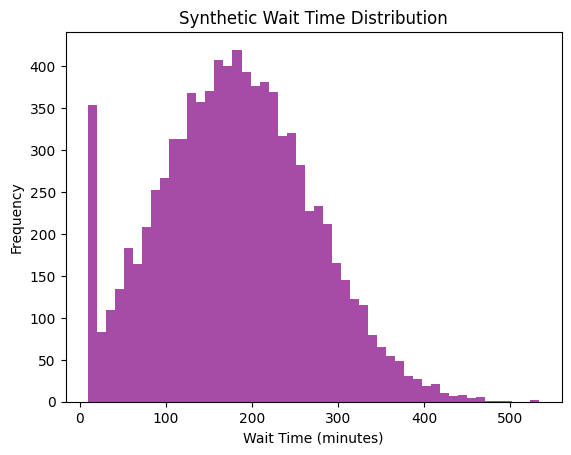

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a date range for hourly data (synthetic data)
idx = pd.date_range(start='2024-01-01', end='2024-12-31', freq="h")

# Generate synthetic wait times with a **Normal distribution**
# Mean=180 mins (3 hours), Std=90 (big variation), Clipped to 10-600 mins
np.random.seed(42)
wait_times = np.random.normal(loc=180, scale=90, size=len(idx))
wait_times = np.clip(wait_times, 10, 600)  # Ensure values stay within a logical range

# Create DataFrame
synthetic_df = pd.DataFrame(index=idx, data=wait_times, columns=["wait_time_minutes"])

# Categorize into Under 4 Hours and Over 4 Hours
synthetic_df['Under_4_Hours'] = (synthetic_df['wait_time_minutes'] <= 240).astype(int)
synthetic_df['Over_4_Hours'] = (synthetic_df['wait_time_minutes'] > 240).astype(int)

# Aggregate by month
synthetic_monthly = synthetic_df.resample('ME').sum()[['Under_4_Hours', 'Over_4_Hours']]
synthetic_monthly['Month'] = synthetic_monthly.index.month
synthetic_monthly.reset_index(drop=True, inplace=True)

# Preview the results
print("\n✅ Synthetic Data (Monthly Aggregates):")
print(synthetic_monthly.head())

# Visualize distribution of synthetic wait times
plt.hist(wait_times, bins=50, color='purple', alpha=0.7)
plt.title("Synthetic Wait Time Distribution")
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Frequency")
plt.show()
